# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2025-02-19 19:05:53--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1 [following]
--2025-02-19 19:05:54--  https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce37532a0ae75e7ea53cd0cc6f8.dl.dropboxusercontent.com/cd/0/inline/CkfGf2OdbD2PveBGtcKmwAspldgaS6ENK6YsGXlKqLvPS7nt0oZ68U_xlJOUeZ4aaL5XIezHD8a2m3oUop1Nb4J7YGmquWm97bFzmQf8a-wLN98M5iAmVZZ9xzjyDse87p0/file# [following]
--2025-02-19 19:05:55--  https://uce37532a0ae75e7ea53cd0cc6f8.dl.dropbo

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<ipython-input-8-2cf9e99ee780>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-8-2cf9e99ee780>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(os.path.join(label_path, image_name))


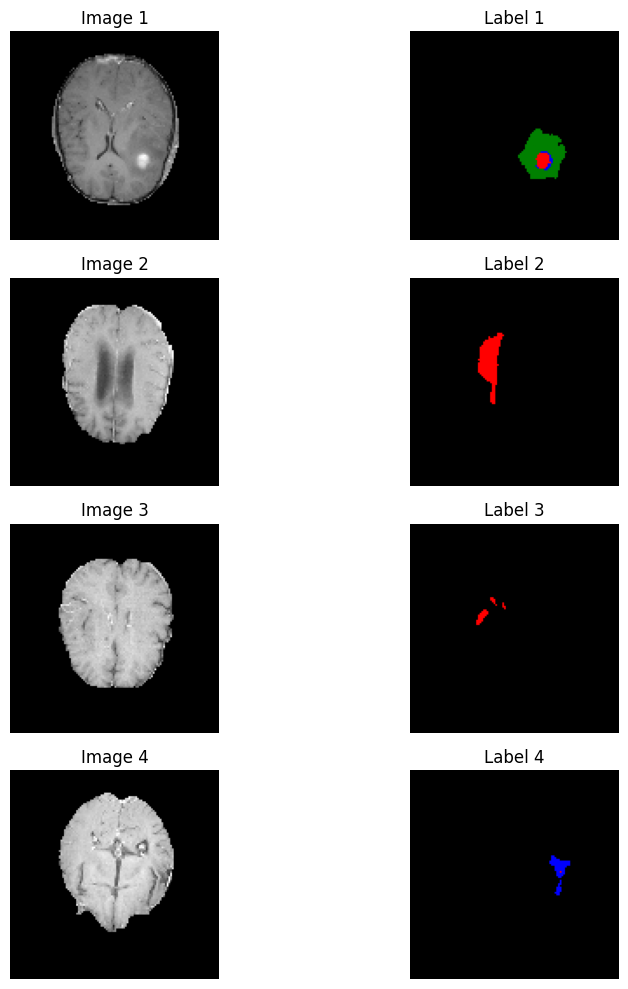

In [8]:
### Insert your code ###
image_path = 'Task01_BrainTumour_2D/training_images'
label_path = 'Task01_BrainTumour_2D/training_labels'
image_names = os.listdir(image_path)
num_samples = 4
indices = random.sample(range(len(image_names)), num_samples)

fig, ax = plt.subplots(num_samples, 2, figsize=(10, 10))
for i, idx in enumerate(indices):
    # print(idx)
    image_name = image_names[idx]
    image = imageio.imread(os.path.join(image_path, image_name))
    label = imageio.imread(os.path.join(label_path, image_name))

    ax[i, 0].imshow(image, cmap='gray')
    ax[i, 0].set_title(f'Image {i+1}')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    ax[i, 1].set_title(f'Label {i+1}')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [86]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    # thres_roi = 1 -> 1-percentile almost all intensity in the image
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        indices = random.sample(range(len(self.images)), batch_size)
        for idx in indices:
            image, label = self.__getitem__(idx)
            images.append(image)
            labels.append(label)

        images = np.stack(images, axis=0)
        labels = np.stack(labels, axis=0)
        images = images[:, np.newaxis, :, :]
        # print('batch shape', images.shape)
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [87]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        # image filtering will be performed n(=16) times
        # nn.Sequential -> a sequential container that applies a series of operations in order
        # two layers of convolution
        # first layer 1 image to 16 features
        # second layer 16 features to 16 features
        # normalize and activation function in between
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        # first layer: 16 -> 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        n //= 2 # 64
        self.upconv3 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv5 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2 # 32
        self.upconv2 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2 # 16
        self.upconv1 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.conv = nn.Sequential(
            nn.Conv2d(n, output_channel, kernel_size=1),
        )
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv3(x)
        x = torch.cat((x, conv3_skip), dim=1)
        x = self.conv5(x)

        x = self.upconv2(x)
        x = torch.cat((x, conv2_skip), dim=1)
        x = self.conv6(x)

        x = self.upconv1(x)
        x = torch.cat((x, conv1_skip), dim=1)
        x = self.conv7(x)

        x = self.conv(x)
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [88]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    # calls the forward function and forward-propagated the image
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    loss = criterion(logits, labels)

    # clear previous gradient
    optimizer.zero_grad()
    # calculate grad
    loss.backward()
    # update parameter
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            # get evaluation batch
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

            # forward pass
            test_logits = model(test_images)
            # calculate loss on eval
            test_loss = criterion(test_logits, test_labels)

            print(f"Interation: {it}, validation Cross Entropy Loss: {test_loss}")
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-86-647308459704>:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-86-647308459704>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Interation: 100, Cross Entropy Loss: 0.4246130585670471
Interation: 200, Cross Entropy Loss: 0.1643422245979309
Interation: 300, Cross Entropy Loss: 0.09576760977506638
Interation: 400, Cross Entropy Loss: 0.0911741554737091
Interation: 500, Cross Entropy Loss: 0.08339465409517288
Interation: 600, Cross Entropy Loss: 0.09216606616973877
Interation: 700, Cross Entropy Loss: 0.0524391308426857
Interation: 800, Cross Entropy Loss: 0.04431673139333725
Interation: 900, Cross Entropy Loss: 0.0424598753452301
Interation: 1000, Cross Entropy Loss: 0.03811251372098923
Interation: 1100, Cross Entropy Loss: 0.04500379413366318
Interation: 1200, Cross Entropy Loss: 0.0405430868268013
Interation: 1300, Cross Entropy Loss: 0.04039807245135307
Interation: 1400, Cross Entropy Loss: 0.030995618551969528
Interation: 1500, Cross Entropy Loss: 0.03119461052119732
Interation: 1600, Cross Entropy Loss: 0.03153777867555618
Interation: 1700, Cross Entropy Loss: 0.03823068365454674
Interation: 1800, Cross Entr

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

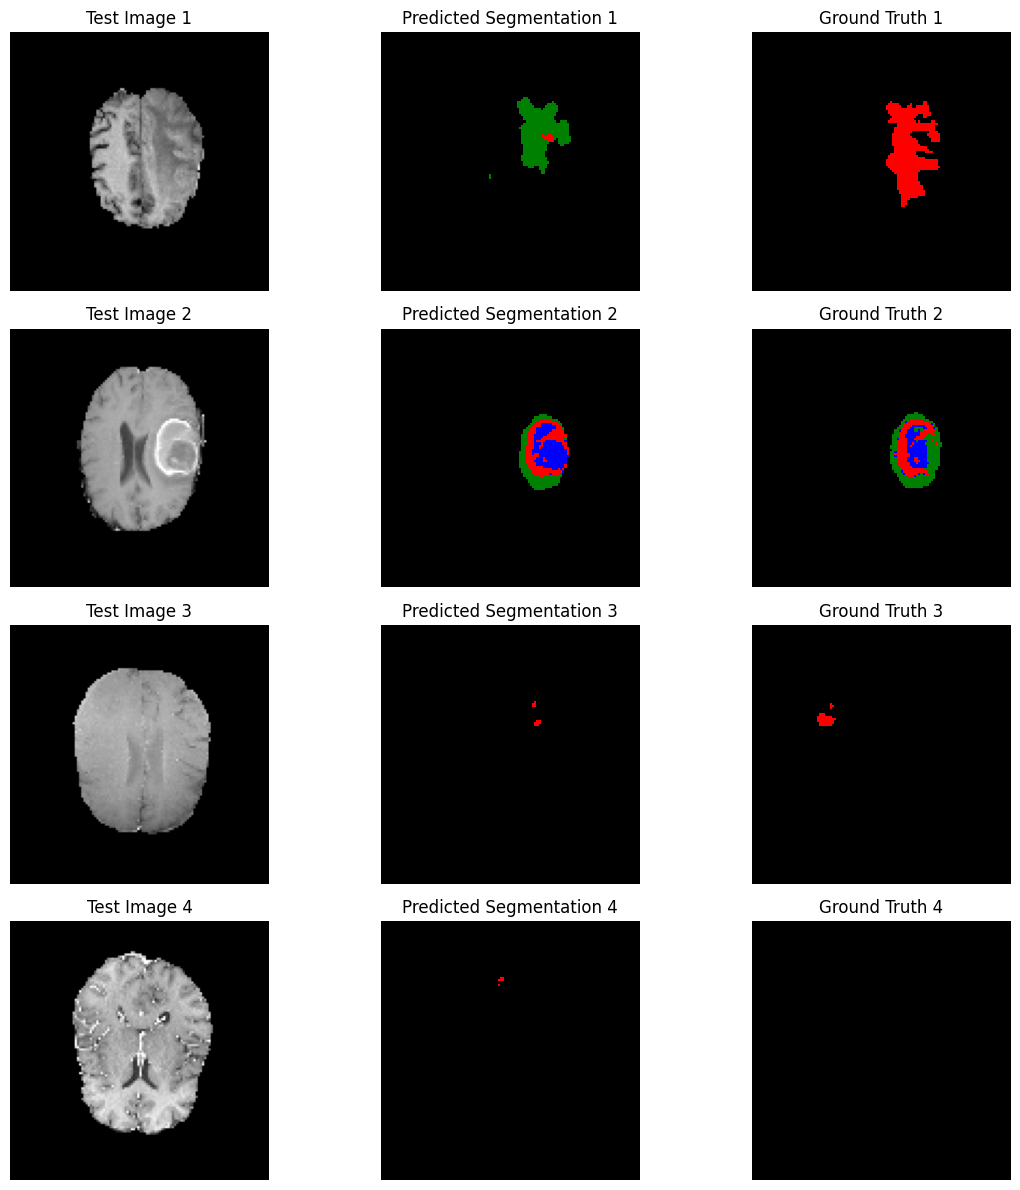

In [93]:
### Insert your code ###
model.eval()

test_images, test_labels = test_set.get_random_batch(num_samples)
test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

test_preds = model(test_images)

test_images = test_images.detach().cpu().numpy().squeeze()  # Remove channel dim if needed
test_preds = torch.argmax(test_preds, dim=1).detach().cpu().numpy()
test_labels = test_labels.detach().cpu().numpy()


label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

fig, ax = plt.subplots(num_samples, 3, figsize=(12, 12))
for i in range(num_samples):
    # Test Image
    ax[i, 0].imshow(test_images[i], cmap='gray')
    ax[i, 0].set_title(f'Test Image {i+1}')
    ax[i, 0].axis('off')

    # Segmentation Prediction
    ax[i, 1].imshow(test_preds[i], cmap=label_cmap, interpolation='nearest')
    ax[i, 1].set_title(f'Predicted Segmentation {i+1}')
    ax[i, 1].axis('off')

    # Ground Truth Segmentation
    ax[i, 2].imshow(test_labels[i], cmap=label_cmap, interpolation='nearest')
    ax[i, 2].set_title(f'Ground Truth {i+1}')
    ax[i, 2].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The trained U-Net model shows a promising performace. We see a steadily decreasing validation loss from 0.42 to around 0.008, which indicates a effective learning. There were no jumps in the validation loss showing that the training followed a relatively smooth path without signs of divergence. This is no strong sign of overfittin. If the model were to overfit, we would expect the training loss to keep decreasing(from continuously updating its parameter) while the validation loss(validated from a completely new dataset) increases.

However, the model needs to be enhanced to be deployed to the real clinic. Looking at the results of running the model against test data, we see false positives, misclassification, and segmentation much smaller than ground truth. This suggests a lot of room for improvement.
To address misclassification, we might be able to implement a weighted cross-entropy loss to give higher weight to underrepresented tumor types so that the modek can learn to differentiate them. It is also possible to implement attention mechanisms to help focus on different tumor regoins. The model displays poor performance on small Tumors. The model might have focused on the majority class that the pixel belongs to and ignored the rare and tiny tumor pixels. Looking at more test images, the model some times fail to capture the more detailed structure of the tumor. This might suggest that the upsampling process was too rough and did not restore all the details captured. We could possibly apply finer upsampling methods or increase the inter-connection between different layers of the pyramid, just like the UNet++. False positive(displayed by the model) is an extremely serious issue in the real-world application. This could be due to the inbalance between class of the training data. It is possible for the model to provide a confidence level to the doctor, who can conduct further checks for the tumor. It could be possible to refine the post-processing of this model. One possible solution could be model ensembling, where multiple models vote for the result of the detection.
